In [1]:
# run with conda activate for_yt

In [2]:
import os,sys
import yt
import numpy as np
from numpy import log10 as log, log as ln
import pyxsim
import soxs
from yt import units as un, physical_constants as cons
sys.path.append('../../pysrc/')

soxs : [WARNING  ] 2024-01-30 15:13:17,881 Setting 'soxs_data_dir' to /Users/jonathanstern/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
import projectPlotBasics

In [4]:
import pylab as pl
import matplotlib
from matplotlib import ticker
figdir = '/Users/jonathanstern/Dropbox/Apps/Overleaf/Analytic2D/'
directory = '/Users/jonathanstern/Dropbox/github_repositories/gizmo_analysis/ipynb/subsonic_solution/snapshots/'


yt : [INFO     ] 2023-12-04 13:21:23,157 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-12-04 13:21:23,157 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-12-04 13:21:23,201 Parameters: current_time              = 3.5499999672174454
yt : [INFO     ] 2023-12-04 13:21:23,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-12-04 13:21:23,202 Parameters: domain_left_edge          = None
yt : [INFO     ] 2023-12-04 13:21:23,202 Parameters: domain_right_edge         = None
yt : [INFO     ] 2023-12-04 13:21:23,202 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-12-04 13:21:23,218 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-12-04 13:21:23,218 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-12-04 13:21:23,254 Parameters: current_time              = 2.44999997317791
yt : [INFO     ] 2023-12-04 13:21:23,255 Parameters: domain_dimensions         = [1 1 1]
yt : [INF

BH position [-0.01702357 -0.03651664 -0.00058411] code_length


yt : [INFO     ] 2023-12-04 13:21:41,021 Allocating for 6.253e+07 particles
yt : [INFO     ] 2023-12-04 13:21:41,022 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2023-12-04 13:21:43,884 Load this dataset with bounding_box=[[-3604.31420898 -3571.93017578 -3585.05371094], [3577.61425781 3607.44946289 3590.23095703]] to avoid I/O overhead from inferring bounding_box.
Initializing coarse index : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:03<00:00, 70.34it/s]
yt : [INFO     ] 2023-12-04 13:21:47,290 Updating index_order2 from 2 to 2
Initializing refined index: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:13<00:00, 16.44it/s]


BH position [ 0.02079579 -0.02846357 -0.00136999] code_length


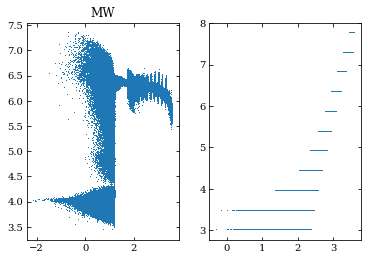

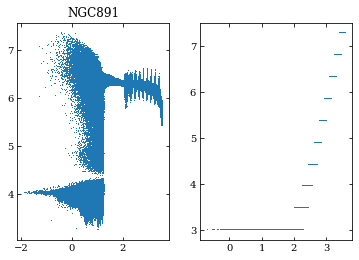

In [5]:
#Rcirc_sim = 10*un.kpc
Rcirc_sim = 15*un.kpc
os.system("rm %s*.ewah"%directory)
#ds = yt.load("/Users/jonathanstern/Downloads/snapshot_324.hdf5")
ds_MW = yt.load(directory+"snapshot_071.hdf5")
ds_NGC891 = yt.load(directory+"snapshot_049.hdf5")
dss = ds_MW,ds_NGC891; names = 'MW','NGC891'
#ds = yt.load("/Users/jonathanstern/Downloads/snapshot_009.hdf5")
for ids,ds in enumerate(dss):
    ad = ds.all_data()
    center = ad[ ('PartType5', 'Coordinates')][0]
    print('BH position', center)
    radius = ((ad[('PartType0','Coordinates')]-center)**2).sum(axis=1)**0.5
    pl.figure()
    pl.subplot(121)
    pl.plot(log(radius),log(ad[('PartType0','temperature')].value),',')
    pl.title(names[ids])
    pl.subplot(122)
    pl.plot(log(ad[('gas','radius')]/3e21),log(ad[('gas','mass')].value/2e33),',')

In [28]:
ds.units.physical_constants.sigma_thompson/ds.units.physical_constants.clight

unyt_quantity(2.21902132e-35, 'cm*s')

In [6]:
def _kSZ_integrand(field, data, coeff = cons.sigma_thompson/cons.c):
    return coeff * data["gas", "El_number_density"] * data["gas", "velocity_x"]
ds = dss[1]
ds.add_field(
    name=("gas", "kSZ_integrand"),
    function=_kSZ_integrand,
    sampling_type="local",
    units="cm**-1",
)

In [7]:
# define hot gas filter
def hot_CGM(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5*un.K
    pfilter2 = data[pfilter.filtered_type, "radius"] < 200*un.kpc
    return pfilter1 & pfilter2
yt.add_particle_filter("hot_gas", function=hot_CGM, filtered_type='gas', requires=["temperature","radius"])
ds.add_particle_filter('hot_gas')

True

In [8]:
#plot = yt.ProjectionPlot(ds, 0, ("gas", "temperature"), center=center,
#                        width=(200,'kpc'),buff_size=(200,200))
#plot.show()

In [63]:
#NGC891
d = 9.52*un.Mpc #Bregmann22
Rcirc = Rcirc_sim 
size_ratio = 1 #(Rcirc/Rcirc_sim).value 
#Rcirc = (13.18/2*un.arcminute).to('radian')*d.to('kpc') #Bregmann22
#size_ratio = (Rcirc/Rcirc_sim).value 
pixel_physical_size = (1*un.arcminute).to('radian')*d.to('kpc') #Battaglia+17
fld = "kSZ_integrand"
width_in_kpc = 150
Npixels = width_in_kpc // pixel_physical_size.value *3
plot = yt.ProjectionPlot(ds, 0, ("hot_gas", fld), center=center,method="integrate",
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
kSZ = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]

yt : [INFO     ] 2023-12-04 13:48:16,592 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-12-04 13:48:16,593 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-12-04 13:48:16,595 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-12-04 13:48:16,596 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-12-04 13:48:16,598 Making a fixed resolution buffer of (('hot_gas', 'kSZ_integrand')) 162 by 162
yt : [INFO     ] 2023-12-04 13:49:17,489 Making a FITS image of field kSZ_integrand


In [ ]:
plot2 = yt.ProjectionPlot(ds, 0, ("gas","kSZ_integrand"),
                  center=center,method="integrate",
                    weight_field=("PartType0",'particle_ones'),
                width=(150,'kpc'),buff_size=(100,100))
a = plot2.to_fits_data()["kSZ_integrand"].data

In [125]:
plot3 = yt.ProjectionPlot(ds, 0, ("gas","kSZ_integrand"),
                  center=center,method="integrate",
                    weight_field=("PartType0",'particle_ones'),
                width=(150,'kpc'),buff_size=(25,25))
b = plot3.to_fits_data()["kSZ_integrand"].data

yt : [INFO     ] 2023-12-04 14:54:01,413 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-12-04 14:54:01,416 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-12-04 14:54:01,418 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-12-04 14:54:01,419 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-12-04 14:54:01,422 Making a fixed resolution buffer of (('gas', 'kSZ_integrand')) 25 by 25
yt : [INFO     ] 2023-12-04 14:54:23,916 Making a fixed resolution buffer of (('PartType0', 'particle_ones')) 25 by 25
yt : [INFO     ] 2023-12-04 14:54:39,873 Making a FITS image of field kSZ_integrand


In [145]:
30e21*0.01*un.cm**-2*cons.sigma_thompson * 200*un.km/un.s/cons.c * 2.7e6

unyt_quantity(0.35948145, '(dimensionless)')

unyt_quantity(0.00100069, '(dimensionless)')

In [136]:
(200*un.km/un.s*cons.sigma_thompson/cons.c* 1e-3*2**-1.5*
 un.cm**-3*20*un.kpc).to('')

unyt_quantity(9.68338094e-09, '(dimensionless)')

In [65]:
maskR, maskz = 20,3
TCMB = 2.726
y = kSZ * 1e6 * TCMB
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<maskR) & (np.abs(Ymesh)<maskz))
y_tuple = X,Y,y * mask

/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_22168/1064967306.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(X,Y,y*mask,cmap='RdBu',vmin=-vrng,vmax=vrng)


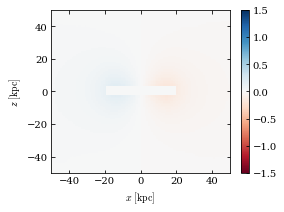

In [66]:
xrng = 50
fig = pl.figure(figsize=(4,3))
ax=pl.subplot(111)
mid,ind = len(Y)//2,np.searchsorted(X,-26)
vrng=1.5
pl.pcolormesh(X,Y,y*mask,cmap='RdBu',vmin=-vrng,vmax=vrng)
pl.colorbar()
pl.ylabel(r'$z\ [{\rm kpc}]$')
pl.xlim(-xrng,xrng)
pl.ylim(-xrng,xrng)
pl.xlabel(r'$x\ [{\rm kpc}]$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

In [91]:
dirds.proj

functools.partial(<class 'yt.data_objects.construction_data_containers.YTParticleProj'>, ds=<weakproxy at 0x7f995bd03cc0 to GizmoDataset at 0x7f9968c2ab20>)

In [60]:
proj=ds.proj(ds=ds,field=('gas', 'sz_kinetic'),axis=1)
frb = proj.to_frb((width_in_kpc,"kpc"), Npixels*3,center=(0,0,0))
k=np.array(frb["gas", "sz_kinetic"])
k_MK = k * 2.7 * 1e6

yt : [INFO     ] 2023-12-04 13:46:57,770 Making a fixed resolution buffer of (('gas', 'sz_kinetic')) 162 by 162


In [96]:
frb.keys()

dict_keys([('gas', 'sz_kinetic')])

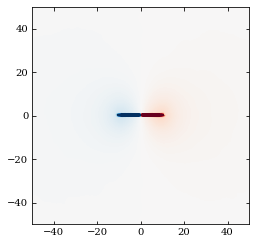

In [61]:
import scipy.ndimage
image2 = k_MK.T #scipy.ndimage.gaussian_filter(k_MK.T, sigma=(3,3))
pl.figure(); ax =pl.subplot(111)
im2 = ax.imshow(image2,cmap='RdBu', extent=[-xrng,xrng,-xrng,xrng], 
                norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))

8.850931677018636


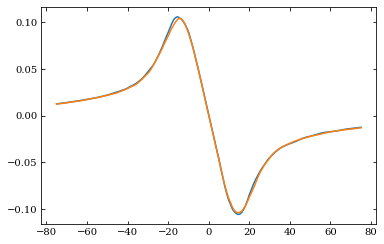

In [68]:
d=30*3; print(X[d]); 
pl.plot(X,y[d,:])
pl.plot(X,image2[d,:])
#pl.plot(X,image2[d,:]/y[d,:],c='k')

In [13]:
emin_in_keV = 0.54
emax_in_keV = 0.59
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
source_model = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)

pyxsim : [INFO     ] 2023-11-16 10:38:38,423 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-11-16 10:38:38,423 kT_max = 64 keV


# plot spectrum with thermal broadening only

In [14]:
sp = ds.sphere(center,200*un.kpc)
spec = source_model.make_spectrum(sp, emin_in_keV,emax_in_keV, nbins)

pyxsim : [INFO     ] 2023-11-16 10:38:38,427 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-11-16 10:38:38,428 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/45759886 [00:00<?, ?it/s]

Text(0.5, 0, 'energy [keV]')

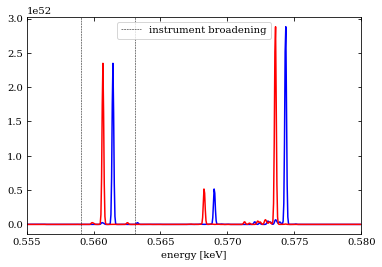

In [15]:
v_th = ((cons.kb*2e6*un.K/(16*cons.mp))**0.5).to('km/s')
v_phi = 200*un.km/un.s
v_inst = 0.002/0.56 * cons.c.to('km/s')

line_center = 0.561065*un.keV
for j in range(2):
    pl.plot(spec.emid*(1+(v_phi/cons.c).to(''))**((-1)**j),spec.flux,c='br'[j])
    pl.axvline(line_center.value*(1+(v_inst/cons.c).to(''))**((-1)**j),c='k',ls='--',lw=0.5,label=('instrument broadening','_')[j])
pl.xlim(0.555,0.58)
pl.legend()
pl.xlabel('energy [keV]')

In [16]:
#single line flux
emin_in_keV = 0.56
emax_in_keV = 0.563 
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2023-11-16 10:42:00,896 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-11-16 10:42:00,897 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.56_0.563_keV'),
 ('gas', 'xray_luminosity_0.56_0.563_keV'),
 ('gas', 'xray_photon_emissivity_0.56_0.563_keV')]

In [17]:
#LEM
Npixels_to_sum = 1 #in one dimension
d=40*un.Mpc
pixel_angular_size  = 15*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 118*2
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')

In [18]:
fld = 'xray_emissivity_0.56_0.563_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)

In [19]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 
cnts = (emission * pixel_area * geometric_dilution  / line_center / (2.35*v_inst/cons.c*line_center)).to('s**-1*keV**-1')

yt : [INFO     ] 2023-11-16 10:42:01,674 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-11-16 10:42:01,675 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-11-16 10:42:01,676 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-11-16 10:42:01,676 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-11-16 10:42:01,677 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 236 by 236
yt : [INFO     ] 2023-11-16 10:43:09,970 Making a FITS image of field xray_emissivity_0.56_0.563_keV


In [48]:
mask = ~((np.abs(Xmesh)<maskR) & (np.abs(Ymesh)<maskz))
pl.pcolormesh(X,Y,cnts*mask,cmap='viridis',vmax=0.05)
pl.colorbar(label=r'OVII 0.56keV counts ${\rm pixel}^{-1}\ {\rm s}^{-1}\ {\rm keV}^{-1}$')
pl.contour(X,Y,cnts,[0.02],c='k') #foreground
pl.xlim(-img_width_physical/2/4,img_width_physical/2/4)
pl.ylim(-img_width_physical/2/4,img_width_physical/2/4)
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')
pl.text(-75,70,r'NGC 891 ($d=9.8\,{\rm Mpc}$)',color='w')
pl.text(-40,-45,'equal to\nforeground',color='k',fontsize=8,ha='center')
pl.plot([-40,-35],[-34,-30],c='k',lw=0.5)

ValueError: operands could not be broadcast together with shapes (236,236) (54,54) 

In [21]:
plot = yt.ProjectionPlot(ds, 0, ("gas","velocity_x"),weight_field=("gas", fld), center=center,
                         method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission_weighted_velocity = plot.to_fits_data()["velocity_x"].data.to('km/s')
emission_weighted_velocity_tuple = X,Y,emission_weighted_velocity*mask

yt : [INFO     ] 2023-11-16 10:43:10,179 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-11-16 10:43:10,180 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-11-16 10:43:10,181 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-11-16 10:43:10,181 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-11-16 10:43:10,182 Making a fixed resolution buffer of (('gas', 'velocity_x')) 236 by 236
yt : [INFO     ] 2023-11-16 10:44:21,339 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 236 by 236
yt : [INFO     ] 2023-11-16 10:45:29,163 Making a FITS image of field velocity_x


In [53]:
X,Y = emission_weighted_velocity_tuple[:2]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<maskR) & (np.abs(Ymesh)<maskz))
emission_weighted_velocity_tuple = X,Y,emission_weighted_velocity*mask

In [61]:
from projectPlotBasics import *


/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_27620/476180225.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(X,Y,vals,cmap='RdBu',vmin=-vrng,vmax=vrng)


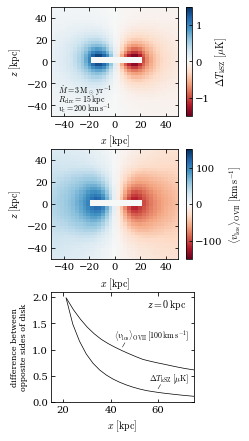

In [502]:
xrng = 50
fig = pl.figure(figsize=(fig_width_half,6))
gs  = matplotlib.gridspec.GridSpec(ncols=1, nrows=3)
gs2  = matplotlib.gridspec.GridSpec(ncols=10, nrows=3)
pl.subplots_adjust(hspace=0.3,left=0.2,right=0.85,wspace=0.4,top=0.99,bottom=0.075)
for iobs in range(2):
    X,Y,vals = (y_tuple,emission_weighted_velocity_tuple)[iobs]
    mid,ind = len(Y)//2,np.searchsorted(X,-26)
    label = (r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$',r'$\langle v_{\rm los}\rangle_{\rm OVII}\ [{\rm km}\,{\rm s}^{-1}]$')[iobs]
    vrng=(1.5,150)[iobs]        
    ax = fig.add_subplot(gs[iobs])
    pl.pcolormesh(X,Y,vals,cmap='RdBu',vmin=-vrng,vmax=vrng)
    pl.colorbar(label=label)
    pl.ylabel(r'$z\ [{\rm kpc}]$')
    pl.xlim(-xrng,xrng)
    pl.ylim(-xrng,xrng)
    pl.xlabel(r'$x\ [{\rm kpc}]$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    if iobs==0:
        pl.text(-45,-45,r'$v_{\rm c}=200\,{\rm km}\,{\rm s}^{-1}$',fontsize=8)
        pl.text(-45,-29,r'$\dot{M}=3\,{\rm M}_\odot\,{\rm yr}^{-1}$',fontsize=8)
        pl.text(-45,-36,r'$R_{\rm c}=15\,{\rm kpc}$',fontsize=8)
ax = fig.add_subplot(gs2[2,:9])
for iobs in range(2):
    if iobs==0:
        X,Y,vals = y_tuple
        label = r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$'
        norm = 1
        pl.text(73,0.4,label,fontsize=8,ha='right')
        pl.plot([61,60],[0.33,0.25],lw=0.5,c='k')
    else:
        X,Y,vals = emission_weighted_velocity_tuple
        norm = 100
        label = r'$\langle v_{\rm los}\rangle_{\rm OVII}\,[%d\,{\rm km}\,{\rm s}^{-1}]$'%norm        
        pl.text(73,1.2,label,fontsize=8,ha='right')
        pl.plot([46,45],[1.13,1.05],lw=0.5,c='k')
    mid,ind = len(Y)//2,np.searchsorted(X,-20)
    pl.plot(X[len(X)-ind:],(vals[mid,:ind][::-1]-vals[mid,len(X)-ind:])/norm,c='k',lw=0.7,ms=3)
pl.text(0.95,0.95,r'$z=0\,{\rm kpc}$',fontsize=10,ha='right',va='top',transform=ax.transAxes)
pl.xlim(15,75)
pl.ylabel('difference between\nopposite sides of disk',fontsize=8)
pl.ylim(0,2.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.savefig(figdir+'observed_velocity.pdf')

In [23]:
r=100*un.kpc
(0.8e-3*cons.mp/0.7*un.cm**-3*2/3*4*np.pi*r**3*(r/(10*un.kpc))**-1.5).to('Msun')/(1e10*un.yr)

unyt_quantity(0.74875843, 'Msun/yr')

In [24]:
T=2e6*un.K
vc=250*un.km/un.s
2*cons.kb*T/(cons.me*cons.c**2) / (vc/cons.c)

unyt_quantity(0.80889759, '(dimensionless)')

# anisotropy

In [229]:
#single line flux
emin_in_keV = 0.5
emax_in_keV = 2
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2023-11-16 15:50:38,010 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-11-16 15:50:38,010 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.5_2_keV'),
 ('gas', 'xray_luminosity_0.5_2_keV'),
 ('gas', 'xray_photon_emissivity_0.5_2_keV')]

In [230]:
#LEM
d=40*un.Mpc
pixel_angular_size  = 1*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 2000
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')


In [472]:
#anisotropy plot
Npixels_to_sum = 1 #in one dimension
d=10*un.Mpc
pixel_angular_size  = 1*un.arcmin 
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #~3kpc
FOV_in_pixels = 100 #+-50'
img_width_physical = pixel_physical_size*FOV_in_pixels #+_150 kpc
img_Npixels = FOV_in_pixels
pixel_area = pixel_physical_size**2 #9kpc^2
telescope_area = 1*un.cm**2
geometric_dilution = (telescope_area / (4*np.pi*d**2)).to('')


In [504]:
fld = 'xray_photon_emissivity_0.5_2_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))

In [233]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 

yt : [INFO     ] 2023-11-16 15:50:38,786 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:50:38,787 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:50:38,788 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:50:38,788 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:50:38,790 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2_keV')) 100 by 100
yt : [INFO     ] 2023-11-16 15:51:37,164 Making a FITS image of field xray_photon_emissivity_0.5_2_keV


In [234]:
cnts = (emission * pixel_physical_size**2 * geometric_dilution).to('s**-1')

In [235]:
#single line flux
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
emin_in_keV = 0.56
emax_in_keV = 0.563 
source_model1 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields1= source_model1.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)
emin_in_keV = 0.64
emax_in_keV = 0.68 
source_model2 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields2= source_model2.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)


pyxsim : [INFO     ] 2023-11-16 15:51:37,228 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-11-16 15:51:37,228 kT_max = 64 keV
pyxsim : [INFO     ] 2023-11-16 15:51:37,245 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-11-16 15:51:37,245 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-11-16 15:51:38,755 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-11-16 15:51:38,755 kT_max = 64 keV
pyxsim : [INFO     ] 2023-11-16 15:51:38,770 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-11-16 15:51:38,770 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

In [236]:
plot = yt.ProjectionPlot(ds, 0, xray_fields1[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVII_emission = plot.to_fits_data()[xray_fields1[0][1]].data 

yt : [INFO     ] 2023-11-16 15:51:40,645 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:51:40,646 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:51:40,646 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:51:40,647 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:51:40,647 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 100 by 100
yt : [INFO     ] 2023-11-16 15:52:38,916 Making a FITS image of field xray_emissivity_0.56_0.563_keV


In [237]:
plot = yt.ProjectionPlot(ds, 0, xray_fields2[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVIII_emission = plot.to_fits_data()[xray_fields2[0][1]].data 

yt : [INFO     ] 2023-11-16 15:52:38,924 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:52:38,924 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:52:38,925 xlim = -145.472568 145.415641
yt : [INFO     ] 2023-11-16 15:52:38,925 ylim = -145.445474 145.442734
yt : [INFO     ] 2023-11-16 15:52:38,926 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.64_0.68_keV')) 100 by 100
yt : [INFO     ] 2023-11-16 15:53:36,138 Making a FITS image of field xray_emissivity_0.64_0.68_keV


In [238]:
ratio = LOVIII_emission/LOVII_emission

/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_27620/1105017108.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'${\rm major}$'+'\n'+r'${\rm axis}$',r'',r'',r'',
/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_27620/1105017108.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'',r'$45$',r'',r'$90$']))


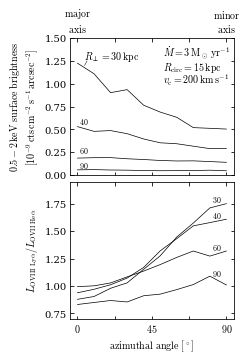

In [508]:
fig = pl.figure(figsize=(3.5,5))
pl.subplots_adjust(hspace=0.05,bottom=0.1,left=0.25)
rs = np.array([30,40,60,90])
thetas=np.linspace(0,np.pi/2,10)
for iPanel in range(2):
    ax = pl.subplot(2,1,iPanel+1)
    for ir,r in enumerate(rs):
        c = 'k'; lw=0.7
        iX = np.searchsorted(X,r*np.sin(thetas))
        iY = np.searchsorted(Y,r*np.cos(thetas))
        if iPanel==0:
            pl.plot(np.pi/2-thetas, cnts[iY,iX]/3600/1e-9,label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c,lw=lw)
        if iPanel==1:
            pl.plot(np.pi/2-thetas, ratio[iY,iX],label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c,lw=lw)
    if iPanel==0:
        pl.text(np.pi/2-1.5,1.27,r'$R_\perp=%d\,{\rm kpc}$'%rs[0],ha='left')
        pl.plot([0.1,0.075],[1.25,1.2],lw=0.5,c='k')
        pl.text(np.pi/2-1.55,0.55,r'$%d$'%rs[1],ha='left',fontsize=8)
        pl.text(np.pi/2-1.55,0.24,r'$%d$'%rs[2],ha='left',fontsize=8)
        pl.text(np.pi/2-1.55,0.075,r'$%d$'%rs[3],ha='left',fontsize=8)        
        pl.ylabel(r'$0.5-2\,{\rm keV}\ {\rm surface}\ {\rm brightness}$'+'\n'
                  +r'$[10^{-9}\,{\rm cts}\,{\rm cm}^{-2}\,{\rm s}^{-1}\,{\rm arcsec}^{-2}]$')        
        pl.ylim(0,1.5)
        #pl.text(0.,0.7,r'$d=10\,{\rm Mpc}$')        
        ax.xaxis.set_label_position('top')                     
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_ticks_position('both')
        pl.text(0.9,1.3,r'$\dot{M}=3\,{\rm M}_\odot\,{\rm yr}^{-1}$',ha='left')
        pl.text(0.9,1.15,r'$R_{\rm c}=15\,{\rm kpc}$',ha='left')
        pl.text(0.9,1.0,r'$v_{\rm c}=200\,{\rm km}\,{\rm s}^{-1}$',ha='left')
        ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'${\rm major}$'+'\n'+r'${\rm axis}$',r'',r'',r'',
                                                            r'${\rm minor}$'+'\n'+r'${\rm axis}$']))        

    if iPanel==1:  
        pl.text(np.pi/2-0.15,1.76,r'$%d$'%rs[0],ha='left',fontsize=8)
        pl.text(np.pi/2-0.15,1.62,r'$%d$'%rs[1],ha='left',fontsize=8)
        pl.text(np.pi/2-0.15,1.325,r'$%d$'%rs[2],ha='left',fontsize=8)
        pl.text(np.pi/2-0.15,1.09,r'$%d$'%rs[3],ha='left',fontsize=8)
        pl.ylabel(r'$L_{\rm OVIII~Ly\alpha}/L_{\rm OVII~He\alpha}$')
        #pl.legend(loc='upper right',frameon=False,handlelength=1,labelspacing=0.15)
        pl.xlabel(r'${\rm azimuthal~angle}\ [^\circ]$')
        pl.ylim(0.7,1.95)
        ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'',r'$45$',r'',r'$90$']))        
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi/2))            
pl.savefig(figdir+'theta_dependence_observed.pdf')

In [36]:
d = 10*un.Mpc
gd = (4*np.pi*d**2)**-1
Mdot = 2*un.Msun/un.yr
vc = 200*un.km/un.s
hnu = 1*un.keV
r = 30*un.kpc
relative_V = (d*(1*un.arcsec).to('radian').value)**2 * r / (4*np.pi*r**3/3)
(Mdot*vc**2 * relative_V / hnu * gd).to('cm**-2*s**-1')

unyt_quantity(1.63942112e-09, '1/(cm**2*s)')

# OVII absorption averaged velocities

In [454]:
ds_MW = yt.load(directory+"snapshot_071.hdf5")
xs = np.linspace(-100,100,400)


yt : [INFO     ] 2023-11-16 18:34:07,084 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-11-16 18:34:07,084 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-11-16 18:34:07,117 Parameters: current_time              = 3.5499999672174454
yt : [INFO     ] 2023-11-16 18:34:07,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-16 18:34:07,118 Parameters: domain_left_edge          = None
yt : [INFO     ] 2023-11-16 18:34:07,119 Parameters: domain_right_edge         = None
yt : [INFO     ] 2023-11-16 18:34:07,119 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-11-16 18:34:07,133 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-11-16 18:34:07,134 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-11-16 18:34:07,160 Parameters: current_time              = 1.549999974668026
yt : [INFO     ] 2023-11-16 18:34:07,160 Parameters: domain_dimensions         = [1 1 1]
yt : [IN

In [455]:
ds = ds_MW
region = ds.r[-100:100:400j, -100:100:400j, -100:100:400j]
n_elec = region[("gas","El_number_density")]
Ts = region[("gas","temperature")]

yt : [INFO     ] 2023-11-16 18:34:07,612 Allocating for 3.145e+07 particles
yt : [INFO     ] 2023-11-16 18:34:07,613 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2023-11-16 18:34:08,986 Load this dataset with bounding_box=[[-3662.6862793  -3697.77832031 -3762.37280273], [3698.10742188 3690.14379883 3575.0012207 ]] to avoid I/O overhead from inferring bounding_box.
Loading particle index: 100%|████████████████████████████████████████████████████| 118/118 [00:00<00:00, 7027.93it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 48900000it [01:04, 753971.21it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 48900000it [01:03, 771310.68it/s] 


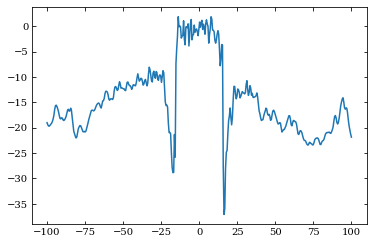

In [624]:
yt_xs  = region[("PartType0","particle_position_x")]
yt_ys  = region[("PartType0","particle_position_y")]
yt_zs  = region[("PartType0","particle_position_z")]
yt_vxs = region[("PartType0","particle_velocity_x")]
yt_vys = region[("PartType0","particle_velocity_y")]
yt_vzs = region[("PartType0","particle_velocity_z")]
yt_jzs = yt_xs*yt_vys - yt_vxs*yt_ys
yt_Rs  = (yt_xs**2+yt_ys**2)**0.5
yt_rs = (yt_xs**2+yt_ys**2+yt_zs**2)**0.5
yt_vphis = yt_jzs/yt_Rs
yt_vrs = yt_vxs*yt_xs/yt_rs + yt_vys*yt_ys/yt_rs + yt_vzs*yt_zs/yt_rs
pl.plot(xs,yt_vrs[:,200,200])
#pl.plot(xs,yt_vxs[200,:,200])
#pl.plot(xs,yt_Rs[:,200,200])
#pl.plot(xs,yt_Rs[200,:,200])
#pl.plot(xs,vphis[200,:,200])
#pl.plot(xs,vphis[200,200,:])

In [625]:
n_O = region[("PartType0","O_nuclei_density")]

In [637]:
Galaxy_coords = [(float(l.split()[2]),
     float(l.split()[3])) for l in open('/Users/jonathanstern/Dropbox/github_repositories/gizmo_analysis/ipynb/subsonic_solution/pyobjs/apj523354t1_ascii.txt').readlines()]

In [639]:
import scipy, scipy.interpolate
center = np.array([0.,0., 0.])
sun_offset = np.array([8.,0., 0.])
max_ray_length = 108
Npoints = 1000
dl = ray_length / Npoints
start_loc = center+sun_offset
avg_vphis = np.zeros(len(Galaxy_coords))
avg_vrs   = np.zeros(len(Galaxy_coords))
for ib,(l,b) in enumerate(Galaxy_coords):
        phi,theta = np.pi-l, np.pi/2-b
        unit_vector = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        points = np.array([(end_loc - start_loc) / Npoints * i for i in np.arange(Npoints)]) + start_loc
        points_rs = (points**2).sum(axis=1)**0.5
        numerator = (scipy.interpolate.interpn((xs,xs,xs),n_O*yt_vphis*(Ts>1e6),points[points_rs<100])).sum()
        denominator = (scipy.interpolate.interpn((xs,xs,xs),n_O*(Ts>1e6),points[points_rs<100])).sum()
        avg_vphis[ib] = numerator/denominator
        numerator = (scipy.interpolate.interpn((xs,xs,xs),n_O*yt_vrs*(Ts>1e6),points[points_rs<100])).sum()
        denominator = (scipy.interpolate.interpn((xs,xs,xs),n_O*(Ts>1e6),points[points_rs<100])).sum()
        avg_vrs[ib] = numerator/denominator

In [644]:
len(Galaxy_coords)

37

[0.5164808888266262, 0.6203149557387896, 0.6899157946018626]
[-0.20731877762858225, -0.09545823460734329, -0.013304445332293508]


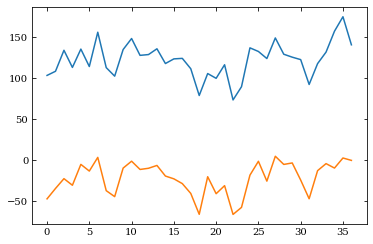

In [643]:
pl.plot(avg_vphis); print([np.percentile(avg_vphis,p)/200 for p in (16,50,84)])
pl.plot(avg_vrs); print([np.percentile(avg_vrs,p)/200 for p in (16,50,84)])

In [ ]:
(3/2*cons.k_B*2e6*un.K *0.62 *cons.m_p / (0.01*un.erg/un.s/un.g)).to('Myr')

In [648]:
15/240,20/240,180/240,41/240

(0.0625, 0.08333333333333333, 0.75, 0.17083333333333334)

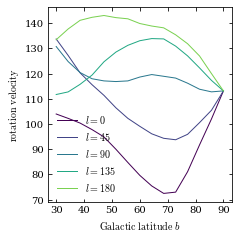

In [628]:
pl.figure(figsize=(3.5,3.6))
ax = pl.subplot(111)
pl.subplots_adjust(left=0.17)
for isim,ds in enumerate(dss[:1]):
    for il,l in enumerate(ls[:]):
        pl.plot(bs/np.pi*180,avg_vphis[l],label=r'$l=%d$'%(l/np.pi*180),
                lw=(1,0.5)[isim],ls=('-',':')[isim],c=pl.get_cmap('viridis')(il/len(ls)))
pl.xlabel(r'${\rm Galactic~latitude}\ b$')
pl.ylabel(r'${\rm rotation~velocity}$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
pl.legend(frameon=False)
#pl.ylim(12,18)
#pl.savefig(figdir+'FRB_DM.pdf')

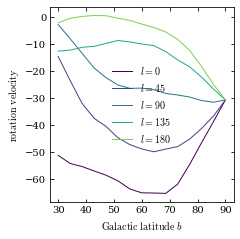

In [629]:
pl.figure(figsize=(3.5,3.6))
ax = pl.subplot(111)
pl.subplots_adjust(left=0.17)
for isim,ds in enumerate(dss[:1]):
    for il,l in enumerate(ls[:]):
        pl.plot(bs/np.pi*180,avg_vrs[l],label=r'$l=%d$'%(l/np.pi*180),
                lw=(1,0.5)[isim],ls=('-',':')[isim],c=pl.get_cmap('viridis')(il/len(ls)))
pl.xlabel(r'${\rm Galactic~latitude}\ b$')
pl.ylabel(r'${\rm rotation~velocity}$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
pl.legend(frameon=False)
#pl.ylim(12,18)
#pl.savefig(figdir+'FRB_DM.pdf')

# FRB columns

In [454]:
ds_MW = yt.load(directory+"snapshot_071.hdf5")
ds_Rcirc10 = yt.load(directory+"snapshot_155.hdf5")
xs = np.linspace(-100,100,400)


yt : [INFO     ] 2023-11-16 18:34:07,084 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-11-16 18:34:07,084 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-11-16 18:34:07,117 Parameters: current_time              = 3.5499999672174454
yt : [INFO     ] 2023-11-16 18:34:07,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-16 18:34:07,118 Parameters: domain_left_edge          = None
yt : [INFO     ] 2023-11-16 18:34:07,119 Parameters: domain_right_edge         = None
yt : [INFO     ] 2023-11-16 18:34:07,119 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-11-16 18:34:07,133 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-11-16 18:34:07,134 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-11-16 18:34:07,160 Parameters: current_time              = 1.549999974668026
yt : [INFO     ] 2023-11-16 18:34:07,160 Parameters: domain_dimensions         = [1 1 1]
yt : [IN

In [455]:
ds = ds_MW
region = ds.r[-100:100:400j, -100:100:400j, -100:100:400j]
n_elec = region[("gas","El_number_density")]
Ts = region[("gas","temperature")]

yt : [INFO     ] 2023-11-16 18:34:07,612 Allocating for 3.145e+07 particles
yt : [INFO     ] 2023-11-16 18:34:07,613 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2023-11-16 18:34:08,986 Load this dataset with bounding_box=[[-3662.6862793  -3697.77832031 -3762.37280273], [3698.10742188 3690.14379883 3575.0012207 ]] to avoid I/O overhead from inferring bounding_box.
Loading particle index: 100%|████████████████████████████████████████████████████| 118/118 [00:00<00:00, 7027.93it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 48900000it [01:04, 753971.21it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 48900000it [01:03, 771310.68it/s] 


In [587]:
ds2 = ds_Rcirc10
region2 = ds2.r[-100:100:400j, -100:100:400j, -100:100:400j]
n_elec2 = region2[("gas","El_number_density")]
Ts2 = region2[("gas","temperature")]

yt : [INFO     ] 2023-11-22 15:25:26,680 Allocating for 1.454e+07 particles
yt : [INFO     ] 2023-11-22 15:25:26,681 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2023-11-22 15:25:27,308 Load this dataset with bounding_box=[[-3165.59423828 -3187.40966797 -3187.77880859], [3198.11303711 3098.51245117 3261.50488281]] to avoid I/O overhead from inferring bounding_box.

Loading particle index: 100%|████████████████████████████████████████████████████| 43/43 [00:00<00:00, 8678.01it/s]

Interpolating SPH field ('PartType0', 'El_number_density'): 0it [00:00, ?it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 50000it [00:00, 484816.65it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 150000it [00:00, 542060.97it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 250000it [00:00, 442053.91it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 300000it [00:00, 368764.91it/s]
I

Interpolating SPH field ('PartType0', 'El_number_density'): 15850000it [00:35, 335495.18it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 15950000it [00:36, 416296.05it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16000000it [00:36, 304903.40it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16100000it [00:36, 329584.16it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16150000it [00:36, 339867.24it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16200000it [00:36, 296888.63it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16300000it [00:37, 378244.77it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16400000it [00:37, 391524.76it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16450000it [00:37, 331502.51it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 16550000it [00:37, 405823.41it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 

Interpolating SPH field ('PartType0', 'Temperature'): 11450000it [00:25, 444089.81it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 11600000it [00:25, 597388.80it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 11700000it [00:25, 548296.22it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 11800000it [00:25, 553301.82it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 11900000it [00:25, 554126.83it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12000000it [00:26, 576035.50it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12100000it [00:26, 490658.50it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12200000it [00:26, 480977.96it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12300000it [00:26, 519635.94it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12400000it [00:26, 545281.79it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 12500000it [00:27, 510964.81it/s]
Interpolating SPH field ('PartTy

In [626]:
import scipy, scipy.interpolate
center = np.array([0.,0., 0.])
sun_offset = np.array([8.,0., 0.])
max_ray_length = 108
Npoints = 1000
dl = ray_length / Npoints
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,15)
ls = np.linspace(0,np.pi,5)
DM = {},{}
for l in ls[:]:
    DM[0][l] = np.zeros(bs.shape)
    DM[1][l] = np.zeros(bs.shape)
    for ib,b in enumerate(bs[:]):
        phi,theta = np.pi-l, np.pi/2-b
        unit_vector = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        points = np.array([(end_loc - start_loc) / Npoints * i for i in np.arange(Npoints)]) + start_loc
        points_rs = (points**2).sum(axis=1)**0.5
        for isim,ds in enumerate(dss[:1]):
            interpolated_n_elec = scipy.interpolate.interpn((xs,xs,xs),(n_elec,n_elec2)[isim],points[points_rs<100])
            interpolated_Ts = scipy.interpolate.interpn((xs,xs,xs),(Ts,Ts2)[isim],points[points_rs<100])
            DM[isim][l][ib] = (interpolated_n_elec * (interpolated_Ts>1e6)).sum()*dl            

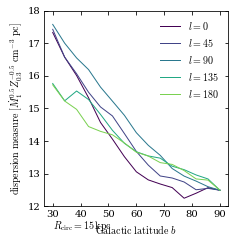

In [457]:
pl.figure(figsize=(3.5,3.6))
ax = pl.subplot(111)
pl.subplots_adjust(left=0.17)
for isim,ds in enumerate(dss[:1]):
    norm = (1.5**0.5,2.7**0.5 * (0.1/0.3)**-0.5)[isim]
    for il,l in enumerate(ls):
        pl.plot(bs/np.pi*180,DM[isim][l]*1000/norm,label=r'$l=%d$'%(l/np.pi*180),
                lw=(1,0.5)[isim],ls=('-',':')[isim],c=pl.get_cmap('viridis')(il/len(ls)))
pl.xlabel(r'${\rm Galactic~latitude}\ b$')
pl.ylabel(r'${\rm dispersion~measure}\ [\dot{M}_1^{0.5}Z_{0.3}^{-0.5}\ {\rm cm}^{-3}\ {\rm pc}]$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
pl.legend(frameon=False)
pl.text(30,11.3,r'$R_{\rm circ}=15\,{\rm kpc}$')
pl.ylim(12,18)
pl.savefig(figdir+'FRB_DM.pdf')

# Andromeda

In [458]:
ray_length = 200
Npoints = 1000
dl = ray_length / Npoints
i = 77/180*np.pi
Rimps = np.array([20,40,60,80])
azimuths = np.linspace(0.01,np.pi*0.99,50)
ts = np.linspace(-ray_length/2,ray_length/2,Npoints)
DM_M31 = {},{}
for Rimp in Rimps:
    DM_M31[0][Rimp] = np.zeros(azimuths.shape)
    DM_M31[1][Rimp] = np.zeros(azimuths.shape)
    for iaz,az in enumerate(azimuths):
        z0 = Rimp/np.sqrt(1+np.tan(az)**2)/np.sin(i)
        x0 = np.sqrt(Rimp**2-z0**2*np.sin(i)**2)
        points = np.array([x0+ts*0,ts*np.sin(i),z0+ts*np.cos(i)]).T
        points_rs = (points**2).sum(axis=1)**0.5
        for isim,ds in enumerate(dss):
            interpolated_n_elec = scipy.interpolate.interpn((xs,xs,xs),(n_elec,n_elec2)[isim],points[points_rs<100])
            interpolated_Ts = scipy.interpolate.interpn((xs,xs,xs),(Ts,Ts2)[isim],points[points_rs<100])
            DM_M31[isim][Rimp][iaz] = interpolated_n_elec.sum()*dl

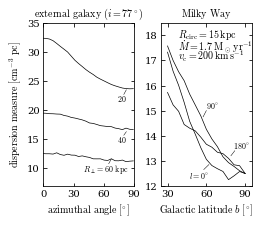

In [522]:
pl.figure(figsize=(fig_width_half*1.1,3)); pl.subplots_adjust(wspace=0.3)
ax = pl.subplot(121)
for isim,ds in enumerate(dss[:1]):
    norm = (1.5**0.5,2.7**0.5 * (0.1/0.3)**-0.5)[isim]
    for iR,Rimp in enumerate(Rimps[:-1]):
        pl.plot(90-azimuths/np.pi*180,DM_M31[isim][Rimp]*1000/norm,
                ls=('-',':')[isim],c='k',lw=0.7)
pl.text(165/2,21.5,r'$20$',ha='right',fontsize=8); pl.plot([160/2,165/2],[22.7,23.5],lw=0.5,c='k')
pl.text(165/2,14.5,r'$40$',ha='right',fontsize=8); pl.plot([160/2,165/2],[15.7,16.3],lw=0.5,c='k')
pl.text(170/2,9.4,r'$R_\perp=60\ {\rm kpc}$',ha='right',fontsize=8); pl.plot([130/2,135/2],[10.8,11.6],lw=0.5,c='k')
pl.xlabel(r'${\rm azimuthal~angle}\ [^{\circ}]$')
pl.ylabel(r'${\rm dispersion~measure}\ [{\rm cm}^{-3}\ {\rm pc}]$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
pl.xlim(0,90); pl.ylim(7,35)
pl.title(r'${\rm external~galaxy}\ (i=77^\circ)$',fontsize=10)
ax = pl.subplot(122)
for isim,ds in enumerate(dss[:1]):
    norm = (1.5**0.5,2.7**0.5 * (0.1/0.3)**-0.5)[isim]
    for il,l in enumerate(ls[::2]):
        pl.plot(bs/np.pi*180,DM[isim][l]*1000/norm,label=r'$l=%d$'%(l/np.pi*180),
                ls=('-',':')[isim],c='k',lw=0.7)
pl.xlabel(r'${\rm Galactic~latitude}\ b\ [^{\circ}]$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
#pl.text(80,12.35,r'$45^{\circ}$'); pl.plot([78,82],[12.22,12.3],lw=0.5,c='k')
pl.text(70,15.1,r'$90^{\circ}$',ha='right',fontsize=8); pl.plot([57.5,60],[14.75,15],lw=0.5,c='k')
pl.text(94,13.5,r'$180^{\circ}$',ha='right',fontsize=8); pl.plot([82,79],[13.4,13.2],lw=0.5,c='k')
pl.text(62,12.3,r'$l=0^{\circ}$',ha='right',fontsize=8); pl.plot([58,62],[12.65,12.85],lw=0.5,c='k')
pl.text(38,18.3,r'$R_{\rm c}=15\,{\rm kpc}$',ha='left',va='top')
#pl.text(50,16.2,r'$r<100\,{\rm kpc}$',ha='left',va='top')
pl.text(38,17.5,r'$v_{\rm c}=200\,{\rm km}\,{\rm s}^{-1}$',ha='left',va='top')
pl.text(38,17.9,r'$\dot{M}=1.7\,{\rm M}_\odot\,{\rm yr}^{-1}$',ha='left',va='top')
pl.xlim(25,95); pl.ylim(12,18.5)
pl.title(r'${\rm Milky~Way}$',fontsize=10)
pl.savefig(figdir+'FRB_DM_M31.pdf')

In [403]:
ls/np.pi

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

b=30, max r=30 kpc, DM=10
b=30, max r=100 kpc, DM=17


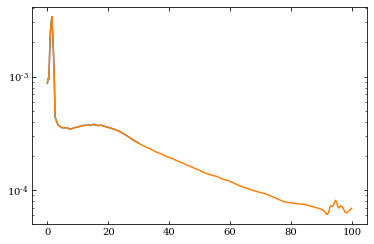

In [359]:
import scipy, scipy.interpolate
center = np.array([0.,0., 0.])
sun_offset = np.array([8.,0., 0.])
Npoints = 1000
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,3)
ray_lengths = np.array([1,2,3,5,10,30,100])
l = np.pi/2
isim = 0
for b in bs[:1]:
    for ir,ray_length in enumerate(ray_lengths[-2:]):
        dl = ray_length / Npoints
        phi,theta = np.pi-l, np.pi/2-b
        unit_vector = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        points = np.array([(end_loc - start_loc) / Npoints * i for i in np.arange(Npoints)]) + start_loc        
        interpolated_n_elec = scipy.interpolate.interpn((xs,xs,xs),(n_elec,n_elec2)[isim],points)
        pl.semilogy(dl*np.arange(Npoints),interpolated_n_elec)
        interpolated_Ts = scipy.interpolate.interpn((xs,xs,xs),(Ts,Ts2)[isim],points)
        #print(interpolated_Ts)
        DM = (interpolated_n_elec * (interpolated_Ts>1e6)).sum()*dl
        print('b=%d, max r=%d kpc, DM=%d'%(b/np.pi*180, ray_length, DM*1000/1.5**0.5))

In [360]:
20e3*3e-4

5.999999999999999

# for ERC presentation

In [29]:
_xs = np.linspace(-200,200,400)
import scipy, scipy.interpolate
ray_length = 100
Npoints = 1000
dl = ray_length / Npoints
b = np.pi*77/180
unit_vector = np.array([0,np.sin(b), np.cos(b)])
xs = np.arange(20,100,2)
ys = np.arange(20,100,2)#/np.cos(b)
DM = np.zeros((xs.shape[0],ys.shape[0]))
for ix,x in enumerate(xs):
    for iy,y in enumerate(ys):
        midpoint  = np.array([x, y, 0.])
        start_loc = midpoint - ray_length * unit_vector
        end_loc   = midpoint + ray_length * unit_vector
        points = np.array([(end_loc - start_loc) / Npoints * i for i in np.arange(Npoints)]) + start_loc
        for isim,ds in enumerate(dss):
            interpolated_n_elec = scipy.interpolate.interpn((_xs,_xs,_xs),(n_elec,n_elec2)[isim],points)
            interpolated_Ts = scipy.interpolate.interpn((_xs,_xs,_xs),(Ts,Ts2)[isim],points)
            DM[ix,iy] = (interpolated_n_elec * (interpolated_Ts>1e6)).sum()*dl

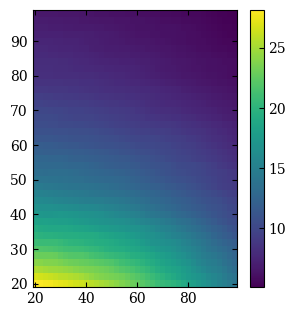

In [30]:
pl.figure(figsize=(3.5,3.6))
ax = pl.subplot(111)
pl.subplots_adjust(left=0.17)
for isim,ds in enumerate(dss[:1]):
    norm = (1.5**0.5,2.7**0.5 * (0.1/0.3)**-0.5)[isim]
    pl.pcolormesh(xs,xs,DM*1000/norm)
pl.colorbar()

In [62]:
obj = ds.arbitrary_grid([-200, -200, -200], [200, 200, 200], dims=[128, 128, 128])


In [68]:
print(obj["deposit", "gas_density"])


YTFieldNotFound: Could not find field ('deposit', 'gas_density') in snapshot_324.

In [78]:
sun_offset = ds.arr([0.,0., 0.], "kpc")
ray_length = 200*un.kpc
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,10)
ls = np.linspace(0,np.pi,5)
DM = {}
for l in ls:
    DM[l] = np.zeros(bs.shape)
    for ib,b in enumerate(bs):
        phi,theta = l, np.pi/2-b
        unit_vector = ds.arr([np.cos(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        my_ray = ds.r[start_loc:end_loc:100j]
        #print(l,b,my_ray["dts"].sum())
        #DM[l][ib] = (my_ray[("gas","El_number_density")] * my_ray["dts"] * (my_ray[("gas","temperature")]>1e6*un.K)).sum()*ray_length

In [84]:
my_ray[("gas","El_number_density")]

YTNonIndexedDataContainer: The data container type (ParticleContainer) is an unindexed type. Operations such as ires, icoords, fcoords and fwidth will not work on it.
Did you just attempt to perform an off-axis operation ? Be sure to consult the latest documentation to see whether the operation you tried is actually supported for your data type.

In [ ]:
exp_time = (300., "ks") # exposure time
area = (1600.0, "cm**2") # collecting area
redshift = 0.002

In [221]:
res = (15*un.arcsecond).to('radian')*d.to('kpc') #LEM paper
size_ratio = (Rcirc/Rcirc_sim).value #better run a sim with correct size
fld = "velocity_x"
width_in_kpc = 100
Npixels = width_in_kpc // res.value
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                         weight_field=xray_fields[0],
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
projected = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]
#plot.set_unit(("hot_gas", "velocity_x"), "km/s")
#plot.save()

yt : [INFO     ] 2022-12-13 15:36:10,777 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,778 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,781 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,782 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,783 Making a fixed resolution buffer of (('gas', 'velocity_x')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:13,222 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:15,606 Making a FITS image of field velocity_x


In [170]:
prj = yt.ProjectionPlot(ds, "z", xray_fields[-1], width=(0.5, "Mpc"))
prj.save()

yt : [INFO     ] 2022-12-13 15:03:36,608 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,610 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,611 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,612 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,613 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_7.0_keV')) 800 by 800
yt : [INFO     ] 2022-12-13 15:03:44,987 Saving plot snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png


['snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png']

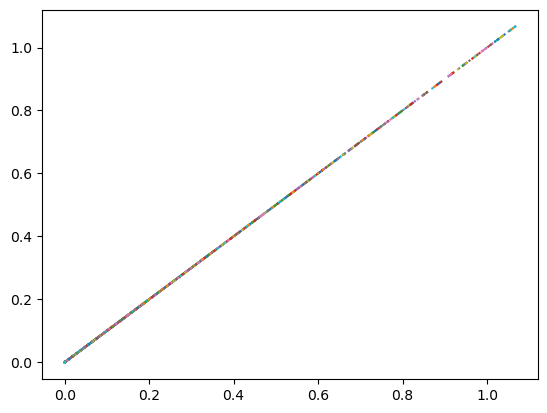

In [149]:
for i in range(len(my_ray["t"])):
    pl.plot([my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]],[my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]])
#%pl.semilogy()

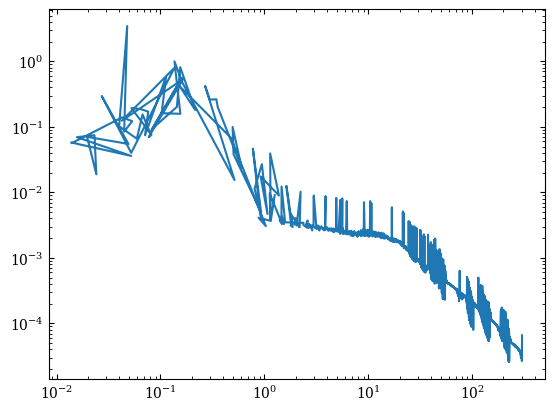

In [56]:
inds = my_ray["t"].argsort()
pl.loglog(my_ray["PartType0","BH_Dist"][inds],my_ray["gas","El_number_density"][inds])

In [57]:
l,b

(3.141592653589793, 1.5707963267948966)

In [88]:
plot = yt.SlicePlot(ds, "r", ("hot_gas", "El_number_density"), center=center,method="integrate")
                        #width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))


ValueError: 'r' is not a valid axis name. Expected one of 'x', 'y', 'z'.

In [ ]:
c_obs = c + ds.arr([8.,0., 0.], "code_length")
c_obs = ds.arr([8.,0., 0.], "code_length")
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max, var_elem=var_elem
)
exp_time = (50., "s") # exposure time
area = (5000.0, "cm**2") # collecting area
redshift = 0.0 # the cosmological redshift of the source, this source is local
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
c = ds.arr([0,0,0], "code_length")
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=bulk_velocity,
                                         observer="internal")
v = ds.arr([0,0,0], "km/s")
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.fields
sp
dir(ds)
ds.field_list
 pyxsim.CIESourceModel?
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","Metallicity_00"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.field_list
ad['PartType0', 'Velocities']
ad['PartType0', 'Velocities'].shape
yt.ProjectionPlot(ds, normal, ("gas", "velocity"), weight_field=("gas", "density")).save()
ys.ProjectionPlot
yt.ProjectionPlot
yt.ProjectionPlot?
yt.ProjectionPlot(ds, 1, ("gas", "velocity"), weight_field=("gas", "density")).save()
%history
dir(ds)
ds.add_field?

ds.add_field(
    name=("PartType0", "velocity_x"),
    function=_velocity_x,
    sampling_type="local",
    units="km/s",
)
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
ds.sphere?
sp = ds.sphere(c, (100.0, "kpc"))
yt.ProjectionPlot(sp, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
sp.field_list
dir(sp)
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
my_sphere = sp
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
def _r(field, data):
    return (data["PartType0","Coordinates"]**2).sum()**0.5
ds.add_field(
    name=("PartType0", "radius"),
    function=_r,
    sampling_type="local",
    units="kpc",
)
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
    
)
plot.save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot.save()
ds.derived_field_list
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
)
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),ylog=False,
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses"")).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("PartType0", "masses")).save()
ds.derived_field_list
yt.ProjectionPlot(ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot?
yt.ProjectionPlot?

In [33]:
87*0.15

13.049999999999999